In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import csv
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import geopandas as gpd

pd.set_option('display.max_columns', 50)

In [2]:
# 2-digit code indicating the Technology of Transmission used to offer broadband service. 
def tech_code_translator(x):
    # ADSL, Cable, Fiber, Fixed Wireless, Satellite, Other
    if x in ['10', '11', '12', '20', '30']:
        return 'ADSL'
    if x in ['40', '41', '42', '43']:
        return 'Cable'
    if x == '50':
        return 'Fiber'
    if x == '60':
        return 'Satellite'
    if x == '70':
        return 'Fixed Wireless'
    return 'Other'
#     if x == '10':
#         return 'Asymetrical xDSL'
#     if x == '11':
#         return 'ADSL2'
#     if x == '12':
#         return 'VDSL' 
#     if x == '20':
#         return 'Symetrical xDSL'
#     if x == '30':
#         return 'Other Copper Wireline'
#     if x == '40':
#         return 'Cable Modem'
#     if x == '41':
#         return 'Cable Modem-DOCSIS1,1.1,2.0'
#     if x == '42':
#         return 'Cable Modem-DOCSIS 3.0'
#     if x == '43': 
#         return 'Cable Modem-DOCSIS 3.1'
#     if x == '50':
#         return 'Optical Carrier/Fiber to the End User'
#     if x == '60':
#         return 'Satellite'
#     if x == '70':
#         return 'Terrestrial Fixed Wireless'
#     if x == '90': 
#         return 'Electric Power Line'
#     if x == '0':
#         return 'Other'
#     return 'NOT VALID'

In [4]:
fcc_data_filepath = '../data/Fixed_Broadband_Deployment_Data__Jun__2019_Status_V1.csv'

converters = {'tract': lambda x: str(x), 
              'block': lambda x: str(x),
              'Technology Code': lambda x: tech_code_translator(x)
             }

data_file = pd.read_csv(fcc_data_filepath, converters = converters, encoding = "ISO-8859-1")
data_file.rename(columns={'Census Block FIPS Code':'FIPS Code'}, inplace=True)
data_file.head()

,Logical Record Number,Provider ID,FRN,Provider Name,DBA Name,Holding Company Name,Holding Company Number,Holding Company Final,State,FIPS Code,Technology Code,Consumer,Max Advertised Downstream Speed (mbps),Max Advertised Upstream Speed (mbps),Business,Max CIR Downstream Speed (mbps),Max CIR Upstream Speed (mbps),county_code,tract,block,boro
0,19376907,50820,4963088,"ViaSat, Inc.",Viasat Inc,"ViaSat, Inc.",290111,"ViaSat, Inc.",NY,360050001000001,Satellite,1,35.0,3.0,1,0.0,0.0,36005,000100,0001,bronx
1,19376908,50820,4963088,"ViaSat, Inc.",Viasat Inc,"ViaSat, Inc.",290111,"ViaSat, Inc.",NY,360050001000002,Satellite,1,35.0,3.0,1,0.0,0.0,36005,000100,0002,bronx
2,19376909,50820,4963088,"ViaSat, Inc.",Viasat Inc,"ViaSat, Inc.",290111,"ViaSat, Inc.",NY,360050001001000,Satellite,1,35.0,3.0,1,0.0,0.0,36005,000100,1000,bronx
3,59544342,52979,1568880,GCI Communication Corp.,GCI Communication Corp.,GCI Holdings LLC,130534,GCI Holdings LLC,NY,360050001001000,Satellite,0,0.0,0.0,1,0.0,0.0,36005,000100,1000,bronx
4,59881129,53153,12369286,"HNS License Sub, LLC",HughesNet,"Hughes Network Systems, LLC",130627,"Hughes Network Systems, LLC",NY,360050001001000,Satellite,1,25.0,3.0,1,0.0,0.0,36005,000100,1000,bronx


In [32]:
tech_codes = ['Cable', 'Fiber']
total_cb = len(data_file['FIPS Code'].unique())

print("There are {} total census blocks in NYC".format(total_cb))

cb_25Mbps = data_file[(data_file["Max Advertised Downstream Speed (mbps)"] >= 25 )&(data_file['Technology Code'].isin(tech_codes))]
cb_1Gbps = data_file[(data_file["Max Advertised Downstream Speed (mbps)"] >= 1000)&(data_file['Technology Code'].isin(tech_codes))]

print("Internet Service Stats for Tech Codes: ", tech_codes)
print("Blocks with access to at least 25 Mbps: {0:.2%}".format(len(cb_25Mbps['FIPS Code'].unique())/total_cb))
print("Blocks with access to at least 01 Gbps: {0:.2%}".format(len( cb_1Gbps['FIPS Code'].unique())/total_cb))

There are 39148 total census blocks in NYC
Internet Service Stats for Tech Codes:  ['Cable', 'Fiber']
Blocks with access to at least 25 Mbps: 96.86%
Blocks with access to at least 01 Gbps: 6.89%


In [47]:
# print("Distinct Providers for: ", tech_code_filter)
provider_count_cols = ['Provider Name', 'Technology Code', 'FIPS Code', 'boro']        
def print_stats(cb_by_providers, cb_count, title=None):
    if title: print(title)
    print("{0:.2%} of census blocks have any options".format(len(cb_by_providers) / cb_count))
    for i in range(1, cb_by_providers['unique_providers'].max()+1):
        count = len(cb_by_providers[cb_by_providers['unique_providers'] == i])
        res = "{0:.4%}".format(count/cb_count)
        print("{} dist. provider(s):".format(i), res)
    print()
        

temp = cb_25Mbps[provider_count_cols].drop_duplicates()[['FIPS Code', 'boro']]
cb25_provider_counts = temp.groupby(['FIPS Code', 'boro'], 
                                  as_index = False).size().reset_index().rename(columns = {0:'unique_providers'})

print_stats(cb25_provider_counts, total_cb, "Distinct Providers of +25 Mbps: {}".format(tech_codes))

temp = cb_1Gbps[provider_count_cols].drop_duplicates()[['FIPS Code', 'boro']]
cb1G_provider_counts = temp.groupby(['FIPS Code', 'boro'], 
                                  as_index = False).size().reset_index().rename(columns = {0:'unique_providers'})

print_stats(cb1G_provider_counts, total_cb, "Distinct Providers of +1 Gbps: {}".format(tech_codes))

Distinct Providers of +25 Mbps: ['Cable', 'Fiber']
96.86% of census blocks have any options
1 dist. provider(s): 18.6932%
2 dist. provider(s): 66.3457%
3 dist. provider(s): 10.6544%
4 dist. provider(s): 1.0933%
5 dist. provider(s): 0.0639%
6 dist. provider(s): 0.0077%

Distinct Providers of +1 Gbps: ['Cable', 'Fiber']
6.89% of census blocks have any options
1 dist. provider(s): 6.0539%
2 dist. provider(s): 0.7995%
3 dist. provider(s): 0.0383%
4 dist. provider(s): 0.0026%



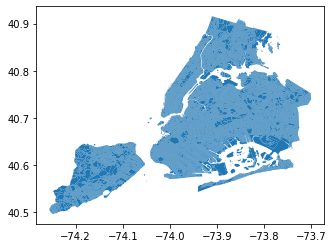

In [48]:
nyc_gpd = gpd.read_file("../data/2010_Census_Blocks/geo_export_7829e0ad-0816-4dbe-b8a1-d10343209019.shp")
nyc_gpd.plot()

In [49]:
boro_to_code = {'manhattan': '36061', 'brooklyn': '36047', 'bronx': '36005', 'queens': '36081', 'staten island':  '36085'}

def getFIPSCode(row):
    return int(boro_to_code[row['boro_name'].lower()] + row['ct2010'] + row['cb2010'])       

def merge_geo(geo_map, cb_data):
    geo_map['FIPS Code'] = geo_map.apply(getFIPSCode, axis=1) #TODO do this when we load nyc_gpd
    geo_map = nyc_gpd.merge(cb_data[['FIPS Code','unique_providers']], on='FIPS Code')
    geo_map['unique_providers'].fillna(0, inplace=True)
    return geo_map

(-74.28337047880757, -73.67222994887423, 40.47515122826259, 40.936362901091314)

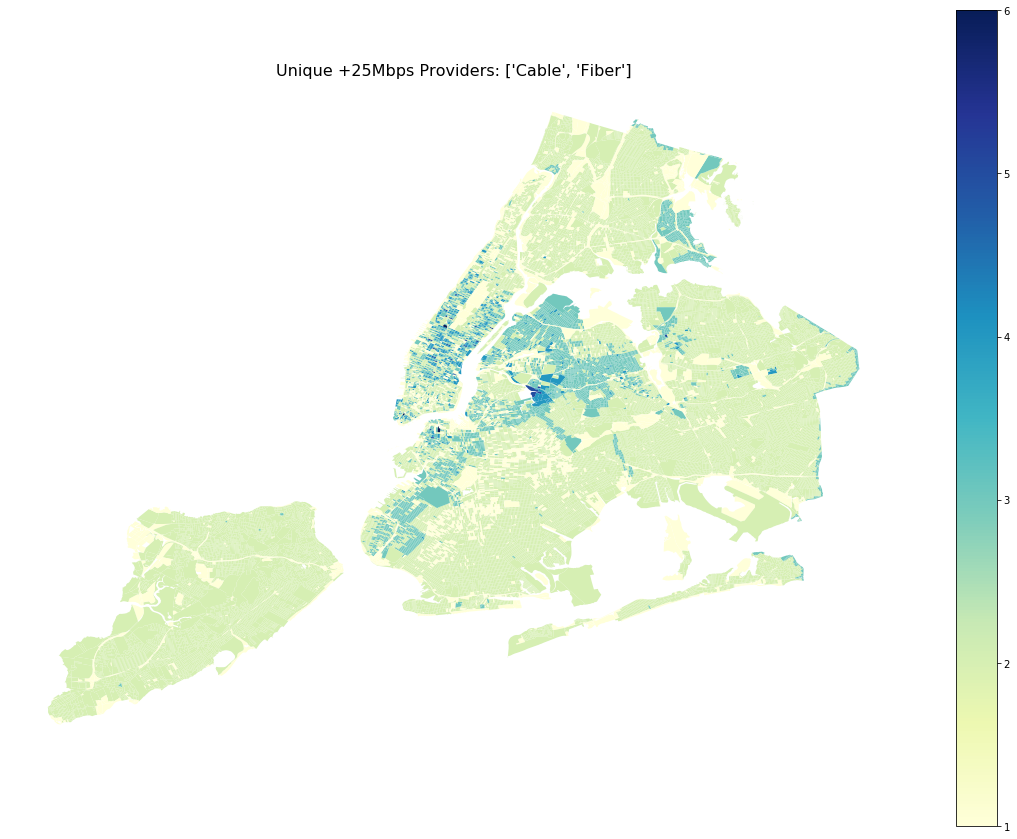

In [54]:
nyc_gpd_25Mbps =  merge_geo(nyc_gpd, cb25_provider_counts)
ax = nyc_gpd_25Mbps.plot(figsize=(20,15), column='unique_providers', cmap='YlGnBu', legend=True, edgecolor="none")
ax.set_title('Unique +25Mbps Providers: '+str(tech_codes), fontdict={'fontsize': 16, 'fontweight' : '3'})
ax.axis('off')

(-74.1531325336164, -73.7373745814835, 40.55937115175016, 40.90435975052114)

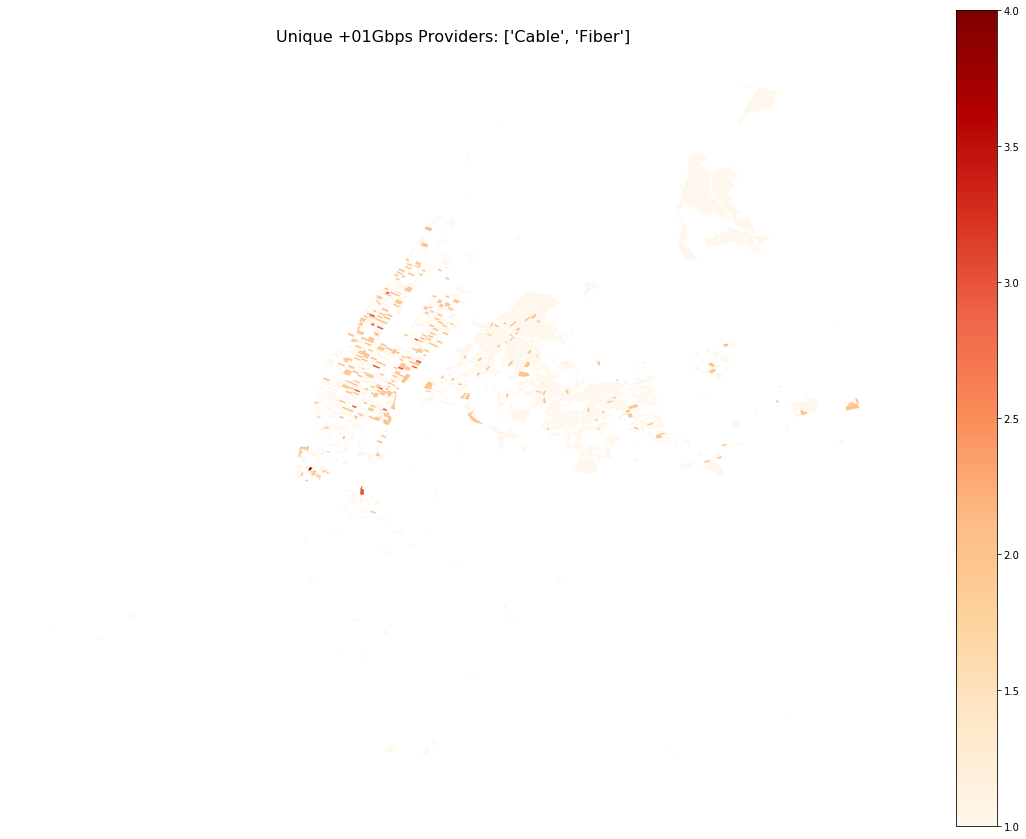

In [56]:
nyc_gpd_1Gbps =  merge_geo(nyc_gpd, cb1G_provider_counts)
ax = nyc_gpd_1Gbps.plot(figsize=(20,15), column='unique_providers', cmap='OrRd', legend=True, edgecolor="none")
ax.set_title('Unique +01Gbps Providers: '+str(tech_codes), fontdict={'fontsize': 16, 'fontweight' : '3'})
ax.axis('off')

In [28]:
print(len(blocksByProviders[blocksByProviders['unique_providers']==1]))
print(blocksByProviders[blocksByProviders['unique_providers']==1].groupby('boro').count())
# blocksByProviders[blocksByProviders['unique_providers']==1]

7318
               FIPS Code  unique_providers
boro                                      
bronx               1312              1312
brooklyn            2419              2419
manhattan           1168              1168
queens              1901              1901
staten island        518               518


In [214]:
len(nyc_gpd[nyc_gpd['unique_providers']>=1])

30004